#Consegna 1: conceptual similarity

* l'esercitazione consiste nell'implementare tre misure di similarità basate su WordNet: *Wu & Palmer, Shortest Path, Leakcock & Chodorow*

* per ciascuna di tali misure di similarità, calcolare gli
indici di correlazione di Spearman and gli indici di
correlazione di Pearson fra i risultati ottenuti e
quelli ‘target’ presenti nel file annotato.

In [ ]:
"""
Authors
Aldo Bushaj 847091
Antonino Bushaj 847013
Silvestro Stefano Frisullo 834813
"""

import math
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from scipy.stats import pearsonr
from scipy.stats import spearmanr

FILE_NAME = 'utils/WordSim353.csv'

#golden similarity è la similarità data dagli umani, è il valore target da raggiungere
#gli altri sono varie similarita degli altri metodi
golden_similarities = []
wup_similarities = []
path_similarities = []
lc_similarities = []

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# https://stackoverflow.com/questions/36206023/wordnet-3-0-maximum-depth-of-the-taxonomy 
#  maxDepth viene  calcolata  con  la seguente funzione, 
# che restituisce 20, ma è commentata perchè richiede circa 12 secondi di esecuzione,
# quindi abbiamo salvato il suo valore.
# 
"""
depth_max = max(max(len(hyp_path) 
for hyp_path in ss.hypernym_paths())
  for ss in wn.all_synsets())
"""
DEPTH_MAX = 20

Lowest Common Subsumer fra i sensi s1 e s2 è il primo antenato comune; e depth(x) è una funzione che misura la
distanza fra la radice di WordNet e il synset x.
In Wordnet un antenato corrisponde ad un iperonimo, da cui il nome della seguente funzione

In [ ]:
#funzione ausiliaria di lowest_common_hypernym che ritorna il primo antenato comune
def max_depth_lambda(elem):
  return elem.max_depth()
"""
  return: il primo antenato comune tra synset1(mela) e synset2(pera), esempio 
  (mela/pera -> frutto -> cibo...)
  None se non hanno un antenato comune
"""
def lowest_common_hypernym(synset1, synset2):
  '''
    tutti gli iperonimi di synset1 e synset2 ordinati per profondità in ordine inverso (reverse=True)
    facciamo uso delle funzioni:
      -max_depth() che calcola la lunghezza del percorso di iperonimi più lungo possibile
       dal synset alla radice ( es per la parola  mela la radice è entità)
      -all_hypernyms() che restituisce tutti gli iperonimi del synset dato
  '''
  all_hypernyms_synset_1 = sorted(all_hypernyms(synset1), key=max_depth_lambda, reverse=True)
  all_hypernyms_synset_2 = sorted(all_hypernyms(synset2), key=max_depth_lambda, reverse=True)

  
  #inseriamo il synset alla prima posizione, traslando il resto
  all_hypernyms_synset_1.insert(0, synset1)
  all_hypernyms_synset_2.insert(0, synset2)

  # Se non hanno un antenato comune ritorno None, esempio nel caso di verbi 
  # appartenenti a differenti gerarchie
  if len(set(all_hypernyms_synset_1).intersection(all_hypernyms_synset_2)) == 0:
    
    return None

  i = 0
  j = 0
  #prendo l'iperonimo comune più profondo risalendo l'albero al contrario
  while all_hypernyms_synset_1[i] != all_hypernyms_synset_2[j]:
      if all_hypernyms_synset_1[i].max_depth() > all_hypernyms_synset_2[j].max_depth():
          i += 1
      else:
          j += 1
  
  

  
  return all_hypernyms_synset_1[i]

Insieme di funzioni ausiliari per


*   Calcolo tutti iperonimi
*   Calcolo distanza tra un synset e un suo antenato
*   Calcolo distanza tra due synset
*   Calcolo profondità massima di un synset



In [ ]:
"""
    :return: preso un synset ritorna tutti i suoi iperonimi
"""
def all_hypernyms(synset):
  #prendo tutti gli iperonimi diretti di synset e li metto in all_hypernyms
  synset_hypernyms = synset.hypernyms()
  for ss in synset.hypernyms(): # per ogni iperonimo

      #extend aggiunge in fondo alla lista gli elementi che le passiamo
      #richiamando ricorsivamente il metodo per prendere gli iperonimi di livello
      #superiore
      synset_hypernyms.extend(all_hypernyms(ss)) 
  return synset_hypernyms


"""
    restituiamo la distanza tra un synset e il suo ancestor
    :input: un synset e il suo antenato
    :return: la distanza tra synset e il suo ancestor
"""
def distance(synset, ancestor):
  #se coincidono la distanza è 0
  if synset == ancestor:
      return 0
  '''
    all'inizio la distanza è infinito, poi calcoliamo la distanza minima tra quella 
    precedente(infinito alla prima chiamata) e quella "attuale + 1" richiamando 
    ricorsivamente se stessa, sommiamo 1 man mano che risaliamo nell'albero. Al caso 
    base restituiamo zero e sommiamo 1 per ogni livello che abbiamo attraversato 
    durante il cammino, quindi le chiamate
  '''
  dist = math.inf
  for ss in synset.hypernyms():
      dist = min(dist, 1 + distance(ss, ancestor))
  return dist

"""
    :return: la distanza minima tra synset1 e synset2. None se i due synset non sono collegabili
"""
def path_distance(synset1, synset2):
  
  #Calcolo il lowest common hyperonym, poi calcolo la distanza tra synset1-hyperonym
  #e synset2-hyperonym e li somma per avere la distanza totale synset1-synset2 ossia
  #del path che li separa
  lowest_common_sense = lowest_common_hypernym(synset1, synset2)
  if lowest_common_sense is not None:
      return distance(synset1, lowest_common_sense) + distance(synset2, lowest_common_sense)
  return None


"""
    :return: la lunghezza massima del cammino dalla radice al synset
"""
def max_depth(synset):
  #caso base: non abbiamo più iperonimi
  if len(synset.hypernyms()) == 0:
      return 0
  #impostiamo la profondità iniziale a -infinito
  depth = -math.inf
  #per ogni iperonimo del synset
  for ss in synset.hypernyms():
      #la profondità è 1 + la profondità, si fa una richiamata ricorsiva della funzione
      depth = max(depth, 1 + max_depth(ss))

  return depth

#Calcolo delle similarità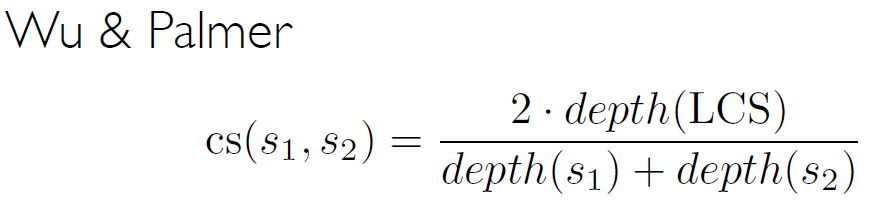


In [ ]:
 """
    Calcolo della misura di similarity di Wu & Palmer
    :input: le due parole di cui calcolare la similarità
    :return: similarità di Wu & Palmer delle parola 
"""
def my_wup_similiarity(word1, word2):
  max_similarity = 0
  #Per ogni synset associato alla parola 1
  for synset1 in wn.synsets(word1):
      #per ogni synset associato alla parola 2
      for synset2 in wn.synsets(word2):
          #Calcolo l'LCS(Lowest Common Subsumer) tra i synset presi a coppia
          lcs = lowest_common_hypernym(synset1, synset2)
          if lcs is not None:
              #Calcolo le varie profondità 
              depth_lcs = max_depth(lcs)
              depth_synset1 = max_depth(synset1)
              depth_synset2 = max_depth(synset2)
              #Infine applico la formula per la similarità
              similarity = (2 * depth_lcs) / (depth_synset1 + depth_synset2)
              #Siccome ripeto per ogni synset, alla fine
              #del ciclo  mi interessa prendere la similarità più alta di tutte
              if similarity > max_similarity:
                  max_similarity = similarity

  return max_similarity


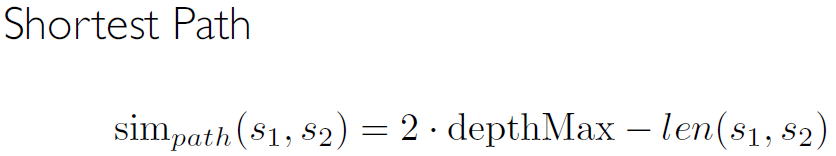

In [ ]:
"""
  Calcolo della similarità con il metodo Shortest Path
  :input: le due parole di cui calcolare la similarità
"""
def my_path_similarity(word1, word2):
    
    max_similarity = 0
    #Per ogni synset associato alla parola 1
    for synset1 in wn.synsets(word1):
        #Per ogni synset associato alla parola 2
        for synset2 in wn.synsets(word2):
            #calcolo la distanza minima fra i due synset
            distance = path_distance(synset1, synset2)
            if distance is not None:
                #Applico la formula, dove depthMax si riferisce alla profondità 
                # massima di WordNet
                similarity = (2 * DEPTH_MAX) - distance
                #Mantengo solo la similarity più alta
                if similarity > max_similarity:
                    max_similarity = similarity

    return max_similarity




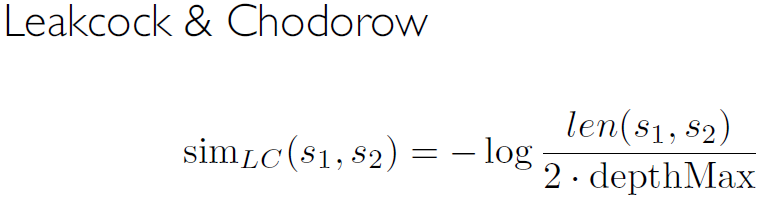

In [ ]:
"""
    Calcolo della misura di similarity di Leakcock & Chodorow
    :input: le due parole di cui calcolare la similarità
"""
def my_lc_similarity(word1, word2):
   
    max_similarity = 0
    #Per ogni synset associato alla parola 1
    for synset1 in wn.synsets(word1):
    #Per ogni synset associato alla parola 2
        for synset2 in wn.synsets(word2):
            #calcolo la distanza tra i due synset
            distance = path_distance(synset1, synset2)

            if distance is not None:
                #applico la formula , aggiungiamo 1 sopra e sotto per normalizzare
                #e non ottenere 0 o infinito col log ottenendo math domain error
                similarity = -math.log((distance +1 ) /
                                       ((2 * DEPTH_MAX) +1 ))
                #mantengo solo la similarità più grande
                if similarity > max_similarity:
                    max_similarity = similarity

    return max_similarity

In [ ]:
"""
    Carica le coppie di parole dal file FILE_NAME e ne calcola le similarità
"""
def load_records_from_file():
    
    file = open(FILE_NAME, "r")
    line = file.readline()

    while line:
        # strip() rimuove gli spazi da inizio o fine della stringa
        line = file.readline().strip()
        if len(line) > 0:
            fields = line.split(',') #separa i campi con una virgola 
            word1 = fields[0] #assegno il primo campo di field in word1
            word2 = fields[1] #assegno il secondo campo di field in word2

            #Calcolo tutte le similarità
            golden_similarities.append(float(fields[2])) #valore di similarità
            wup_similarities.append(my_wup_similiarity(word1, word2))
            path_similarities.append(my_path_similarity(word1, word2))
            lc_similarities.append(my_lc_similarity(word1, word2))




if __name__ == '__main__':

   
    # Carico le coppie di parole dal file e ne calcolo le similarità
    load_records_from_file()
    print('Loaded', len(golden_similarities), 'records.')
    print()

    # indici di correlazione di Pearson da libreria
    pears_correlation_wup, pears_pvalue_wup = pearsonr(golden_similarities, wup_similarities)
    pears_correlation_path, pears_pvalue_path = pearsonr(golden_similarities, path_similarities)
    pears_correlation_lc, pears_pvalue_lc = pearsonr(golden_similarities, lc_similarities)

    # indici di correlazione di Spearman
    spear_correlation_wup, spear_pvalue_wup = spearmanr(golden_similarities, wup_similarities)
    spear_correlation_path, spear_pvalue_path = spearmanr(golden_similarities, path_similarities)
    spear_correlation_lc, spear_pvalue_lc = spearmanr(golden_similarities, lc_similarities)

    print("Pearson - Wu & Palmer:", pears_correlation_wup)
    print("Pearson - Shortest Path:", pears_correlation_path)
    print("Pearson - Leakcock & Chodorow:", pears_correlation_lc)
    print("Spearman - Wu & Palmer:", spear_correlation_wup)
    print("Spearman - Shortest Path:", spear_correlation_path)
    print("Spearman - Leakcock & Chodorow:", spear_correlation_lc)

Loaded 353 records.

Pearson - Wu & Palmer: 0.283626865895621
Pearson - Shortest Path: 0.06076977778187217
Pearson - Leakcock & Chodorow: 0.2669322925028884
Spearman - Wu & Palmer: 0.3279827899055232
Spearman - Shortest Path: 0.26855573998484195
Spearman - Leakcock & Chodorow: 0.26855573998484195


**Output**
Loaded 353 records.

Pearson - Wu & Palmer: 0.283626865895621

Pearson - Shortest Path: 0.06076977778187217

Pearson - Leakcock & Chodorow: 0.2669322925028884

Spearman - Wu & Palmer: 0.3279827899055232

Spearman - Shortest Path: 0.26855573998484195

Spearman - Leakcock & Chodorow: 0.26855573998484195